In [1]:
# Cell 1: Install required packages
!pip install pytube whisper-openai faiss-cpu scikit-learn transformers sentence-transformers torch torchvision tqdm pytorchvideo pandas matplotlib opencv-python pytesseract scenedetect yt-dlp psycopg2-binary pgvector rank_bm25 pillow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.7/132.7 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.3/173.3 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 120.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.9 MB/s eta 0:00:00
 

In [2]:
# Cell 2: Import necessary libraries
import os
import re
import json
import time
import torch
import faiss
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from pytube import YouTube
from transformers import CLIPProcessor, CLIPModel
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from rank_bm25 import BM25Okapi
import whisper
from PIL import Image
from datetime import datetime, timedelta
from IPython.display import display, HTML

In [4]:
# Cell 3: Download the video
def download_youtube_video(youtube_url, output_path='.'):
    """Download YouTube video."""
    print(f"Downloading video from {youtube_url}...")
    yt = YouTube(youtube_url)

    # Get the highest resolution stream
    stream = yt.streams.filter(progressive=True).get_highest_resolution()
    video_path = stream.download(output_path=output_path)

    print(f"Video downloaded to: {video_path}")
    return video_path

# Specify the YouTube URL
# youtube_url = "https://www.youtube.com/watch?v=dARr3lGKwk8"
# video_path = download_youtube_video(youtube_url)

# Alternative download method with yt-dlp if pytube fails
!yt-dlp -f 'bestvideo[ext=mp4]+bestaudio[ext=m4a]/best[ext=mp4]/best' -o video.mp4 {youtube_url}
video_path = "video.mp4"


[youtube] Extracting URL: https://www.youtube.com/watch?v=dARr3lGKwk8
[youtube] dARr3lGKwk8: Downloading webpage
[youtube] dARr3lGKwk8: Downloading tv client config
[youtube] dARr3lGKwk8: Downloading player aa3fc80b-main
[youtube] dARr3lGKwk8: Downloading tv player API JSON
[youtube] dARr3lGKwk8: Downloading ios player API JSON
[youtube] dARr3lGKwk8: Downloading m3u8 information
[info] dARr3lGKwk8: Downloading 1 format(s): 137+140
[download] Destination: video.f137.mp4
[download] 100% of   77.76MiB in 00:00:03 at 25.26MiB/s
[download] Destination: video.f140.m4a
[download] 100% of   58.00MiB in 00:00:02 at 22.65MiB/s
[Merger] Merging formats into "video.mp4"
Deleting original file video.f140.m4a (pass -k to keep)
Deleting original file video.f137.mp4 (pass -k to keep)


In [5]:
# Cell 4: Extract audio and generate transcript
def extract_audio(video_path, output_path="audio.mp3"):
    """Extract audio from video file."""
    print("Extracting audio...")
    command = f"ffmpeg -i '{video_path}' -q:a 0 -map a '{output_path}' -y"
    os.system(command)
    return output_path

def transcribe_audio(audio_path):
    """Transcribe audio using Whisper."""
    print("Transcribing audio with Whisper...")
    model = whisper.load_model("base")
    result = model.transcribe(audio_path, verbose=True)
    return result

# Extract audio
audio_path = extract_audio(video_path)

# Transcribe audio
transcript_result = transcribe_audio(audio_path)


Extracting audio...
Transcribing audio with Whisper...


100%|███████████████████████████████████████| 139M/139M [00:02<00:00, 50.3MiB/s]


Detecting language using up to the first 30 seconds. Use `--language` to specify the language
Detected language: English
[00:00.000 --> 00:08.240]  So, hello everyone. Welcome to the PC Seminar. Today we have this professor Amir Mohad from
[00:08.240 --> 00:13.080]  American University of Beirut and he'll be talking on the girth and parametrious complex
[00:13.080 --> 00:17.760]  at your token sliding and token jumping. Thank you for joining us professor, over to
[00:17.760 --> 00:26.080]  you now. Thank you, President. Thank you for having me. It's a real pleasure to be here.
[00:26.080 --> 00:32.240]  So, all right, let's jump right into it. So, since I did not really know the audience
[00:32.240 --> 00:40.040]  too well, I made the assumption that many of you maybe have not seen this area of combinatorial
[00:40.040 --> 00:45.920]  reconfiguration problems. So, I decided what I'm going to do is I'm going to give a gentle
[00:45.920 --> 00:51.520]  introduction to the area just to sh

In [6]:
# Cell 5: Process transcript into segments
def process_transcript(transcript_result, segment_duration=10):
    """Process transcript into time-based segments."""
    segments = []

    for segment in transcript_result["segments"]:
        start_time = segment["start"]
        end_time = segment["end"]
        text = segment["text"]

        segments.append({
            "start_time": start_time,
            "end_time": end_time,
            "duration": end_time - start_time,
            "text": text,
            "timestamp": format_timestamp(start_time)
        })

    # Save segments to file
    with open('transcript_segments.json', 'w') as f:
        json.dump(segments, f, indent=4)

    print(f"Created {len(segments)} transcript segments")
    return segments

def format_timestamp(seconds):
    """Format seconds to HH:MM:SS."""
    return str(timedelta(seconds=seconds))

# Process transcript into segments
transcript_segments = process_transcript(transcript_result)

# Display a sample of segments
print("\nSample transcript segments:")
for segment in transcript_segments[:3]:
    print(f"[{segment['timestamp']}] {segment['text']}")


Created 512 transcript segments

Sample transcript segments:
[0:00:00]  So, hello everyone. Welcome to the PC Seminar. Today we have this professor Amir Mohad from
[0:00:08.240000]  American University of Beirut and he'll be talking on the girth and parametrious complex
[0:00:13.080000]  at your token sliding and token jumping. Thank you for joining us professor, over to


In [7]:
# Cell 6: Extract video frames
def extract_frames(video_path, sample_rate=5):
    """Extract frames from video at a given sample rate (1 frame every N seconds)."""
    print(f"Extracting frames from video at 1 frame every {sample_rate} seconds...")

    # Create frames directory if it doesn't exist
    frames_dir = "frames"
    os.makedirs(frames_dir, exist_ok=True)

    # Open the video file
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate frame indices to extract
    frame_indices = np.arange(0, total_frames, fps * sample_rate)

    frames_data = []

    for i, frame_idx in enumerate(tqdm(frame_indices)):
        # Set frame position
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        ret, frame = cap.read()

        if not ret:
            continue

        # Save frame
        frame_path = os.path.join(frames_dir, f"frame_{i:05d}.jpg")
        cv2.imwrite(frame_path, frame)

        # Calculate timestamp
        timestamp_seconds = frame_idx / fps

        frames_data.append({
            "frame_id": i,
            "frame_path": frame_path,
            "timestamp": timestamp_seconds,
            "timestamp_formatted": format_timestamp(timestamp_seconds)
        })

    cap.release()

    # Save frames data to file
    with open('frames_data.json', 'w') as f:
        json.dump(frames_data, f, indent=4)

    print(f"Extracted {len(frames_data)} frames")
    return frames_data

# Extract frames
frames_data = extract_frames(video_path)

# Display a sample of frames data
print("\nSample frames data:")
for frame in frames_data[:3]:
    print(f"Frame {frame['frame_id']}: {frame['timestamp_formatted']}")


Extracting frames from video at 1 frame every 5 seconds...


100%|██████████| 752/752 [03:15<00:00,  3.85it/s]

Extracted 752 frames

Sample frames data:
Frame 0: 0:00:00
Frame 1: 0:00:05
Frame 2: 0:00:10


In [8]:
# Cell 7: Generate text embeddings
def generate_text_embeddings(segments):
    """Generate embeddings for transcript segments."""
    print("Generating text embeddings...")

    # Initialize sentence transformer
    model = SentenceTransformer('all-MiniLM-L6-v2')  # You can choose different models from MTEB leaderboard

    texts = [segment["text"] for segment in segments]
    embeddings = model.encode(texts, show_progress_bar=True)

    # Add embeddings to segments
    for i, segment in enumerate(segments):
        segment["text_embedding"] = embeddings[i].tolist()

    # Save segments with embeddings
    with open('segments_with_text_embeddings.json', 'w') as f:
        json.dump(segments, f, indent=4)

    print(f"Generated text embeddings of dimension {embeddings.shape[1]}")
    return segments, embeddings

# Generate text embeddings
segments_with_embeddings, text_embeddings = generate_text_embeddings(transcript_segments)

Generating text embeddings...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Generated text embeddings of dimension 384


In [9]:
# Cell 8: Generate image embeddings
def generate_image_embeddings(frames_data):
    """Generate embeddings for video frames using CLIP."""
    print("Generating image embeddings...")

    # Initialize CLIP
    model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
    processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)

    frame_embeddings = []

    for frame in tqdm(frames_data):
        # Load image
        image = Image.open(frame["frame_path"])

        # Process image
        inputs = processor(images=image, return_tensors="pt").to(device)

        # Generate embedding
        with torch.no_grad():
            outputs = model.get_image_features(**inputs)

        # Normalize the embeddings
        embedding = outputs.cpu().numpy()[0]
        embedding = embedding / np.linalg.norm(embedding)

        # Add embedding to frame data
        frame["image_embedding"] = embedding.tolist()
        frame_embeddings.append(embedding)

    frame_embeddings = np.array(frame_embeddings)

    # Save frames with embeddings
    with open('frames_with_embeddings.json', 'w') as f:
        json.dump(frames_data, f, indent=4)

    print(f"Generated image embeddings of dimension {frame_embeddings.shape[1]}")
    return frames_data, frame_embeddings

# Generate image embeddings
frames_with_embeddings, image_embeddings = generate_image_embeddings(frames_data)


Generating image embeddings...


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]


100%|██████████| 752/752 [00:39<00:00, 19.25it/s]


Generated image embeddings of dimension 512


In [10]:
# Cell 9: Set up FAISS for semantic retrieval
def setup_faiss(embeddings, index_type="flat"):
    """Set up FAISS index for fast similarity search."""
    print(f"Setting up FAISS {index_type} index...")

    d = embeddings.shape[1]  # embedding dimension

    if index_type == "flat":
        index = faiss.IndexFlatIP(d)  # Inner product (cosine similarity on normalized vectors)
    elif index_type == "ivfflat":
        # For larger datasets, IVF is more efficient
        nlist = 100  # number of clusters
        quantizer = faiss.IndexFlatIP(d)
        index = faiss.IndexIVFFlat(quantizer, d, nlist, faiss.METRIC_INNER_PRODUCT)
        index.train(embeddings)

    # Add vectors to the index
    index.add(embeddings)

    return index

# Set up FAISS index for text embeddings
text_faiss_index = setup_faiss(text_embeddings)

# Set up FAISS index for image embeddings
image_faiss_index = setup_faiss(image_embeddings)


Setting up FAISS flat index...
Setting up FAISS flat index...


In [11]:
# Cell 10: Set up lexical retrieval (TF-IDF and BM25)
def setup_tfidf(segments):
    """Set up TF-IDF vectorizer for lexical retrieval."""
    print("Setting up TF-IDF...")

    texts = [segment["text"] for segment in segments]

    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(texts)

    return vectorizer, tfidf_matrix

def setup_bm25(segments):
    """Set up BM25 for lexical retrieval."""
    print("Setting up BM25...")

    tokenized_corpus = [segment["text"].lower().split() for segment in segments]
    bm25 = BM25Okapi(tokenized_corpus)

    return bm25

# Set up TF-IDF
tfidf_vectorizer, tfidf_matrix = setup_tfidf(transcript_segments)

# Set up BM25
bm25_model = setup_bm25(transcript_segments)

Setting up TF-IDF...
Setting up BM25...


In [12]:
# Cell 11: Define retrieval functions
def semantic_text_retrieval(query, top_k=5):
    """Retrieve most relevant transcript segments using semantic search."""
    print(f"Performing semantic text retrieval for: '{query}'")

    # Encode query
    model = SentenceTransformer('all-MiniLM-L6-v2')
    query_embedding = model.encode([query])[0]

    # Normalize embedding
    query_embedding = query_embedding / np.linalg.norm(query_embedding)
    query_embedding = query_embedding.reshape(1, -1).astype('float32')

    # Search
    start_time = time.time()
    distances, indices = text_faiss_index.search(query_embedding, top_k)
    end_time = time.time()

    results = []
    for i, (dist, idx) in enumerate(zip(distances[0], indices[0])):
        if idx < len(transcript_segments):
            segment = transcript_segments[idx]
            results.append({
                "segment_id": idx,
                "start_time": segment["start_time"],
                "end_time": segment["end_time"],
                "timestamp": segment["timestamp"],
                "text": segment["text"],
                "score": float(dist),
                "rank": i + 1
            })

    print(f"Search completed in {(end_time - start_time)*1000:.2f} ms")
    return results

def semantic_image_retrieval(query, top_k=5):
    """Retrieve most relevant video frames using semantic search."""
    print(f"Performing semantic image retrieval for: '{query}'")

    # Initialize CLIP
    model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
    processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)

    # Process text
    inputs = processor(text=[query], return_tensors="pt", padding=True).to(device)

    # Generate embedding
    with torch.no_grad():
        text_features = model.get_text_features(**inputs)

    # Normalize embedding
    query_embedding = text_features.cpu().numpy()[0]
    query_embedding = query_embedding / np.linalg.norm(query_embedding)
    query_embedding = query_embedding.reshape(1, -1).astype('float32')

    # Search
    start_time = time.time()
    distances, indices = image_faiss_index.search(query_embedding, top_k)
    end_time = time.time()

    results = []
    for i, (dist, idx) in enumerate(zip(distances[0], indices[0])):
        if idx < len(frames_data):
            frame = frames_data[idx]
            results.append({
                "frame_id": frame["frame_id"],
                "timestamp": frame["timestamp"],
                "timestamp_formatted": frame["timestamp_formatted"],
                "frame_path": frame["frame_path"],
                "score": float(dist),
                "rank": i + 1
            })

    print(f"Search completed in {(end_time - start_time)*1000:.2f} ms")
    return results

def tfidf_retrieval(query, top_k=5):
    """Retrieve most relevant transcript segments using TF-IDF."""
    print(f"Performing TF-IDF retrieval for: '{query}'")

    # Transform query
    query_vector = tfidf_vectorizer.transform([query])

    # Calculate similarities
    start_time = time.time()
    similarities = (tfidf_matrix @ query_vector.T).toarray().flatten()

    # Get top results
    top_indices = similarities.argsort()[::-1][:top_k]
    end_time = time.time()

    results = []
    for i, idx in enumerate(top_indices):
        segment = transcript_segments[idx]
        score = similarities[idx]
        results.append({
            "segment_id": idx,
            "start_time": segment["start_time"],
            "end_time": segment["end_time"],
            "timestamp": segment["timestamp"],
            "text": segment["text"],
            "score": float(score),
            "rank": i + 1
        })

    print(f"Search completed in {(end_time - start_time)*1000:.2f} ms")
    return results

def bm25_retrieval(query, top_k=5):
    """Retrieve most relevant transcript segments using BM25."""
    print(f"Performing BM25 retrieval for: '{query}'")

    # Process query
    tokenized_query = query.lower().split()

    # Calculate scores
    start_time = time.time()
    scores = bm25_model.get_scores(tokenized_query)

    # Get top results
    top_indices = scores.argsort()[::-1][:top_k]
    end_time = time.time()

    results = []
    for i, idx in enumerate(top_indices):
        segment = transcript_segments[idx]
        score = scores[idx]
        results.append({
            "segment_id": idx,
            "start_time": segment["start_time"],
            "end_time": segment["end_time"],
            "timestamp": segment["timestamp"],
            "text": segment["text"],
            "score": float(score),
            "rank": i + 1
        })

    print(f"Search completed in {(end_time - start_time)*1000:.2f} ms")
    return results

def multimodal_fusion_retrieval(query, top_k=5, alpha=0.5):
    """Combine text and image retrieval scores for multimodal retrieval."""
    print(f"Performing multimodal fusion retrieval for: '{query}'")

    # Get text and image results
    text_results = semantic_text_retrieval(query, top_k=top_k*2)
    image_results = semantic_image_retrieval(query, top_k=top_k*2)

    # Create a mapping of timestamp to results
    fusion_results = {}

    # Process text results
    for result in text_results:
        timestamp = result["start_time"]

        if timestamp not in fusion_results:
            fusion_results[timestamp] = {
                "timestamp": timestamp,
                "timestamp_formatted": format_timestamp(timestamp),
                "text": result["text"],
                "text_score": result["score"],
                "image_score": 0,
                "combined_score": alpha * result["score"]
            }
        else:
            fusion_results[timestamp]["text_score"] = result["score"]
            fusion_results[timestamp]["combined_score"] += alpha * result["score"]

    # Process image results - match to nearest text segment
    for result in image_results:
        img_timestamp = result["timestamp"]

        # Find closest text segment
        closest_timestamp = min(
            [seg["start_time"] for seg in transcript_segments],
            key=lambda x: abs(x - img_timestamp)
        )

        if closest_timestamp not in fusion_results:
            # Find the corresponding text segment
            closest_segment = next(seg for seg in transcript_segments if seg["start_time"] == closest_timestamp)

            fusion_results[closest_timestamp] = {
                "timestamp": closest_timestamp,
                "timestamp_formatted": format_timestamp(closest_timestamp),
                "text": closest_segment["text"],
                "text_score": 0,
                "image_score": result["score"],
                "combined_score": (1 - alpha) * result["score"]
            }
        else:
            fusion_results[closest_timestamp]["image_score"] = result["score"]
            fusion_results[closest_timestamp]["combined_score"] += (1 - alpha) * result["score"]

    # Sort by combined score and take top k
    sorted_results = sorted(
        fusion_results.values(),
        key=lambda x: x["combined_score"],
        reverse=True
    )[:top_k]

    # Add rank
    for i, result in enumerate(sorted_results):
        result["rank"] = i + 1

    return sorted_results

In [18]:
# Cell 12: Gold test set (you will complete later)
def create_gold_test_set():
    """Create a gold standard test set for evaluation."""
    # This will be filled in later according to the assignment
    answerable_questions = [
        {"question": "What is 15-puzzle?", "answer_timestamp": 284},
        {"question": "What is a reconfiguration step in 15-puzzle?", "answer_timestamp": 354},
        {"question": "What is the Graph Coloring Problem?", "answer_timestamp": 684},
        {"question": "What is the token jumping rule", "answer_timestamp": 840},
        {"question": "What is token sliding?", "answer_timestamp": 857},
        {"question": "What is PSPACE", "answer_timestamp": 1080},
        {"question": "How can you parametrize token jumping and token sliding?", "answer_timestamp": 1440},
        {"question": "What is the Lemma on FPT on {C3, C4} free graphs", "answer_timestamp": 2825},
    ]

    unanswerable_questions = [
        {"question": "Who invented the telephone?", "answer": "Not in video"},
        {"question": "What is the capital of France?", "answer": "Not in video"},
        {"question": "How many planets are in the solar system?", "answer": "Not in video"},
        {"question": "What is the speed of light?", "answer": "Not in video"},
        {"question": "When was the first computer built?", "answer": "Not in video"}
    ]

    return {
        "answerable": answerable_questions,
        "unanswerable": unanswerable_questions
    }

# Initialize gold test set
gold_test_set = create_gold_test_set()


In [19]:
# Cell 13: Evaluation function
def evaluate_retrieval_method(method_name, retrieval_function, gold_test_set, top_k=3):
    """Evaluate a retrieval method on the gold test set."""
    print(f"\nEvaluating {method_name}...")

    results = {
        "method": method_name,
        "correct_answerable": 0,
        "total_answerable": len(gold_test_set["answerable"]),
        "correct_unanswerable": 0,
        "total_unanswerable": len(gold_test_set["unanswerable"]),
        "latencies": []
    }

    # Evaluate answerable questions
    print("Evaluating answerable questions...")
    for i, q in enumerate(gold_test_set["answerable"]):
        print(f"  Question {i+1}/{results['total_answerable']}: {q['question']}")

        start_time = time.time()
        retrieved = retrieval_function(q["question"], top_k=top_k)
        end_time = time.time()
        latency = (end_time - start_time) * 1000  # ms
        results["latencies"].append(latency)

        # Check if any retrieved timestamp matches the ground truth
        if q["answer_timestamp"] is not None:
            correct = any(
                abs(result.get("start_time", result.get("timestamp", 0)) - q["answer_timestamp"]) < 10  # within 10 seconds
                for result in retrieved
            )
            results["correct_answerable"] += int(correct)

    # Evaluate unanswerable questions
    print("Evaluating unanswerable questions...")
    for i, q in enumerate(gold_test_set["unanswerable"]):
        print(f"  Question {i+1}/{results['total_unanswerable']}: {q['question']}")

        start_time = time.time()
        retrieved = retrieval_function(q["question"], top_k=1)
        end_time = time.time()
        latency = (end_time - start_time) * 1000  # ms
        results["latencies"].append(latency)

        # For unanswerable questions, we want low confidence scores
        # This is a simplified approach - in practice, you'd want to set a threshold
        score = retrieved[0].get("score", 0) if retrieved else 0
        if score < 0.5:  # Arbitrary threshold
            results["correct_unanswerable"] += 1

    # Calculate metrics
    results["answerable_accuracy"] = results["correct_answerable"] / results["total_answerable"] if results["total_answerable"] > 0 else 0
    results["unanswerable_accuracy"] = results["correct_unanswerable"] / results["total_unanswerable"] if results["total_unanswerable"] > 0 else 0
    results["overall_accuracy"] = (results["correct_answerable"] + results["correct_unanswerable"]) / (results["total_answerable"] + results["total_unanswerable"])
    results["average_latency"] = sum(results["latencies"]) / len(results["latencies"]) if results["latencies"] else 0

    print(f"Results for {method_name}:")
    print(f"  Answerable accuracy: {results['answerable_accuracy']:.2f}")
    print(f"  Unanswerable accuracy: {results['unanswerable_accuracy']:.2f}")
    print(f"  Overall accuracy: {results['overall_accuracy']:.2f}")
    print(f"  Average latency: {results['average_latency']:.2f} ms")

    return results


In [22]:
# Cell 14: Run a simple test query (run this to ensure everything is working)
def test_query(query):
    """Test all retrieval methods with a query."""
    print(f"\nTesting retrieval methods with query: '{query}'")

    print("\n1. Semantic Text Retrieval:")
    text_results = semantic_text_retrieval(query)
    for r in text_results[:3]:
        print(f"  [{r['timestamp']}] ({r['score']:.4f}) {r['text']}")

    print("\n2. Semantic Image Retrieval:")
    image_results = semantic_image_retrieval(query)
    for r in image_results[:3]:
        print(f"  [{r['timestamp_formatted']}] ({r['score']:.4f}) Frame {r['frame_id']}")

    print("\n3. TF-IDF Retrieval:")
    tfidf_results = tfidf_retrieval(query)
    for r in tfidf_results[:3]:
        print(f"  [{r['timestamp']}] ({r['score']:.4f}) {r['text']}")

    print("\n4. BM25 Retrieval:")
    bm25_results = bm25_retrieval(query)
    for r in bm25_results[:3]:
        print(f"  [{r['timestamp']}] ({r['score']:.4f}) {r['text']}")

    print("\n5. Multimodal Fusion:")
    fusion_results = multimodal_fusion_retrieval(query)
    for r in fusion_results[:3]:
        print(f"  [{r['timestamp_formatted']}] (Text: {r['text_score']:.4f}, Image: {r['image_score']:.4f}, Combined: {r['combined_score']:.4f})")
        print(f"    {r['text']}")

# Test with a sample query
test_query("Who is the speaker in the beggining of the video?")



Testing retrieval methods with query: 'Who is the speaker in the beggining of the video?'

1. Semantic Text Retrieval:
Performing semantic text retrieval for: 'Who is the speaker in the beggining of the video?'
Search completed in 0.13 ms
  [0:01:46.400000] (0.2591)  and Karl Lomar, who is my master's student. All right, so the outline of the talk, it's going
  [0:00:26.080000] (0.2576)  So, all right, let's jump right into it. So, since I did not really know the audience
  [0:01:39.440000] (0.2575)  almost two years ago. And it's joint work with Valentine Bartet, Niko Labuske, Le Mandalard,

2. Semantic Image Retrieval:
Performing semantic image retrieval for: 'Who is the speaker in the beggining of the video?'
Search completed in 0.24 ms
  [0:31:00] (0.2365) Frame 372
  [0:00:00] (0.2345) Frame 0
  [0:03:20] (0.2277) Frame 40

3. TF-IDF Retrieval:
Performing TF-IDF retrieval for: 'Who is the speaker in the beggining of the video?'
Search completed in 0.37 ms
  [0:04:16.880000] (0.37


Running full evaluation...

Evaluating Semantic Text...
Evaluating answerable questions...
  Question 1/8: What is 15-puzzle?
Performing semantic text retrieval for: 'What is 15-puzzle?'
Search completed in 0.14 ms
  Question 2/8: What is a reconfiguration step in 15-puzzle?
Performing semantic text retrieval for: 'What is a reconfiguration step in 15-puzzle?'
Search completed in 0.13 ms
  Question 3/8: What is the Graph Coloring Problem?
Performing semantic text retrieval for: 'What is the Graph Coloring Problem?'
Search completed in 0.10 ms
  Question 4/8: What is the token jumping rule
Performing semantic text retrieval for: 'What is the token jumping rule'
Search completed in 0.11 ms
  Question 5/8: What is token sliding?
Performing semantic text retrieval for: 'What is token sliding?'
Search completed in 0.12 ms
  Question 6/8: What is PSPACE
Performing semantic text retrieval for: 'What is PSPACE'
Search completed in 0.10 ms
  Question 7/8: How can you parametrize token jumping 

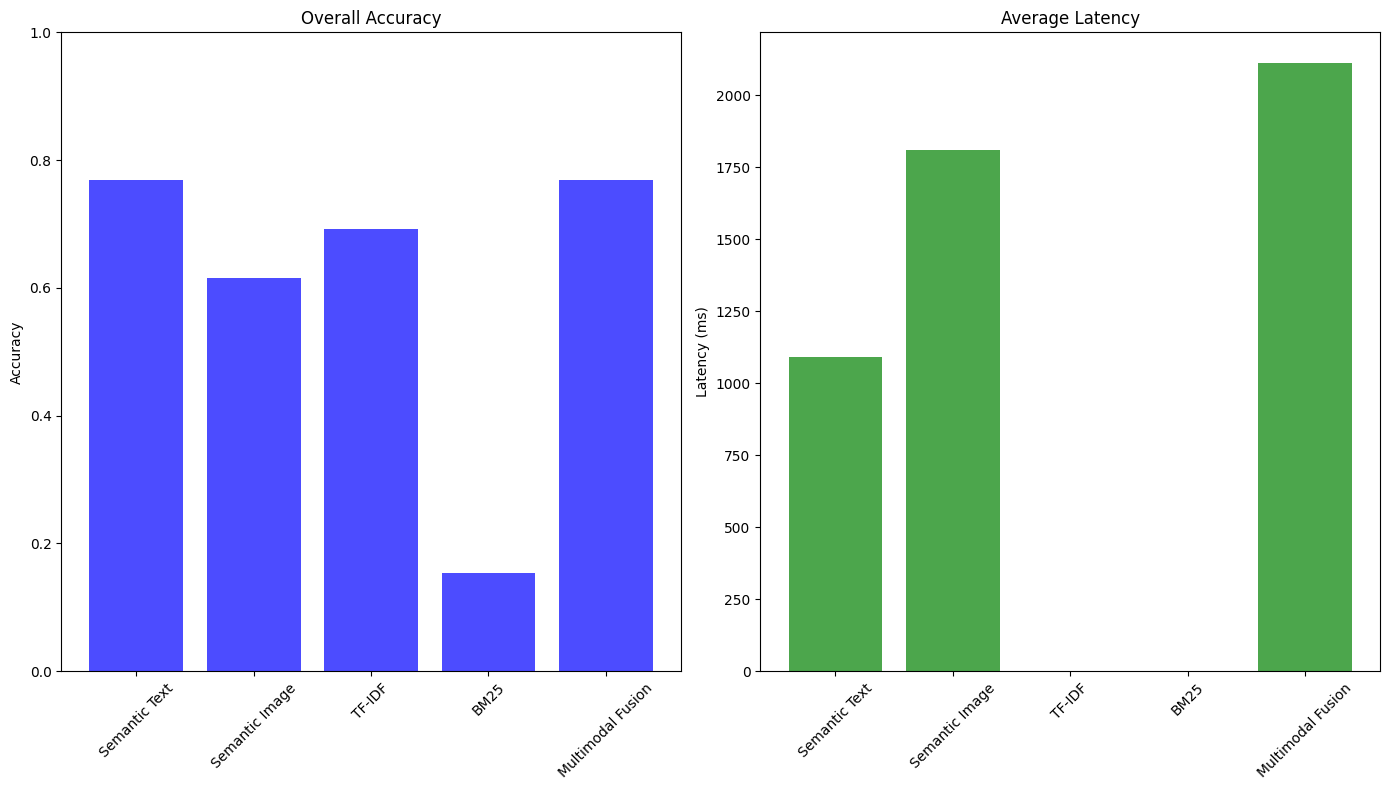

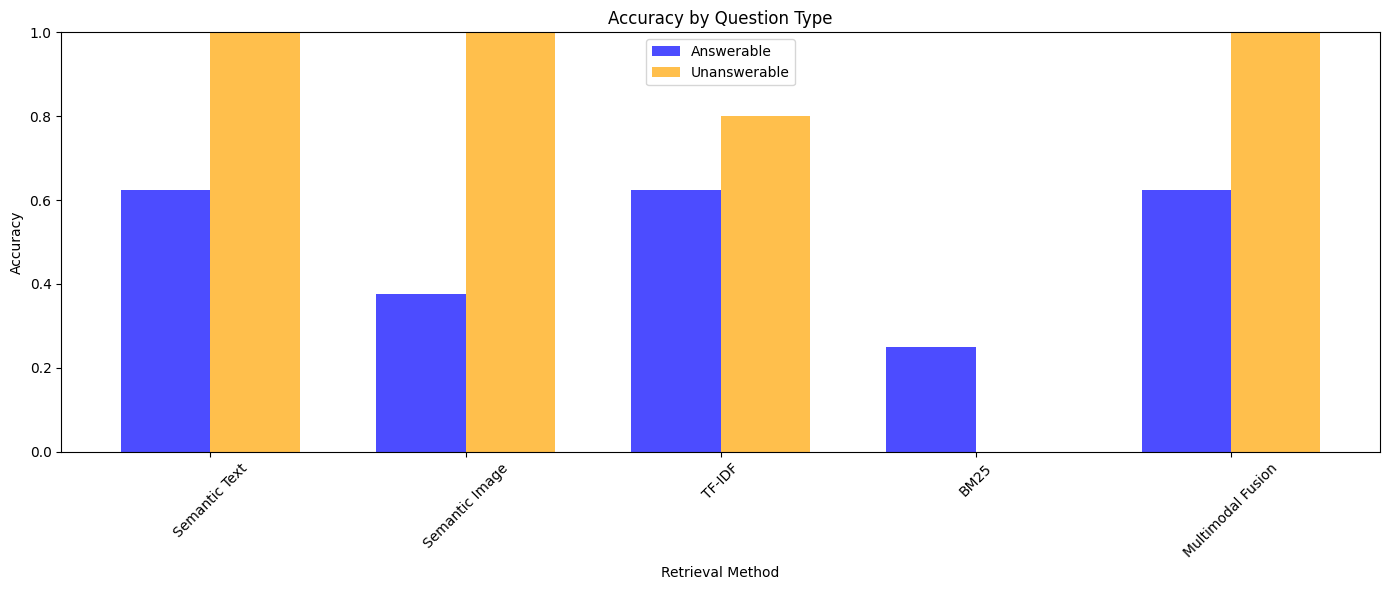


Detailed Evaluation Results:
              method  answerable_accuracy  unanswerable_accuracy  \
0      Semantic Text                0.625                    1.0   
1     Semantic Image                0.375                    1.0   
2             TF-IDF                0.625                    0.8   
3               BM25                0.250                    0.0   
4  Multimodal Fusion                0.625                    1.0   

   overall_accuracy  average_latency  
0          0.769231      1089.873461  
1          0.615385      1811.038347  
2          0.692308         0.950428  
3          0.153846         0.641511  
4          0.769231      2113.115036  

Evaluation results saved to evaluation_results.csv


In [23]:
# Cell 16: Run full evaluation
def run_full_evaluation(gold_test_set):
    """Run a full evaluation of all retrieval methods."""
    print("\nRunning full evaluation...")

    evaluation_results = []

    # Evaluate each method
    evaluation_results.append(evaluate_retrieval_method("Semantic Text", semantic_text_retrieval, gold_test_set))
    evaluation_results.append(evaluate_retrieval_method("Semantic Image", semantic_image_retrieval, gold_test_set))
    evaluation_results.append(evaluate_retrieval_method("TF-IDF", tfidf_retrieval, gold_test_set))
    evaluation_results.append(evaluate_retrieval_method("BM25", bm25_retrieval, gold_test_set))
    evaluation_results.append(evaluate_retrieval_method("Multimodal Fusion", multimodal_fusion_retrieval, gold_test_set))

    # Create comparison table
    df = pd.DataFrame(evaluation_results)

    # Plot results
    plt.figure(figsize=(14, 8))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.bar(df["method"], df["overall_accuracy"], color="blue", alpha=0.7)
    plt.title("Overall Accuracy")
    plt.ylabel("Accuracy")
    plt.ylim(0, 1)
    plt.xticks(rotation=45)

    # Plot latency
    plt.subplot(1, 2, 2)
    plt.bar(df["method"], df["average_latency"], color="green", alpha=0.7)
    plt.title("Average Latency")
    plt.ylabel("Latency (ms)")
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

    # Additional visualization - answerable vs unanswerable accuracy
    plt.figure(figsize=(14, 6))
    x = np.arange(len(df["method"]))
    width = 0.35

    plt.bar(x - width/2, df["answerable_accuracy"], width, label="Answerable", color="blue", alpha=0.7)
    plt.bar(x + width/2, df["unanswerable_accuracy"], width, label="Unanswerable", color="orange", alpha=0.7)

    plt.xlabel("Retrieval Method")
    plt.ylabel("Accuracy")
    plt.title("Accuracy by Question Type")
    plt.xticks(x, df["method"], rotation=45)
    plt.legend()
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()

    # Print detailed results
    print("\nDetailed Evaluation Results:")
    print(df[["method", "answerable_accuracy", "unanswerable_accuracy", "overall_accuracy", "average_latency"]])

    return df

# Run full evaluation
evaluation_df = run_full_evaluation(gold_test_set)

# Export results to CSV
evaluation_df.to_csv("evaluation_results.csv", index=False)
print("\nEvaluation results saved to evaluation_results.csv")